In [1]:
from pyspark.sql import SparkSession

In [4]:
Spark = SparkSession.builder.appName("ML using pyspark").getOrCreate()
df = Spark.read.csv('F:/bank.csv',header = True,inferSchema = True)

In [5]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [7]:
import pandas as pd
pd.DataFrame(df.take(5),columns = df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [10]:
#converting pyspark df to pandas using toPandas()
pdf = df.toPandas()

In [14]:
pdf.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [18]:
#getting continous values and describing the values
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


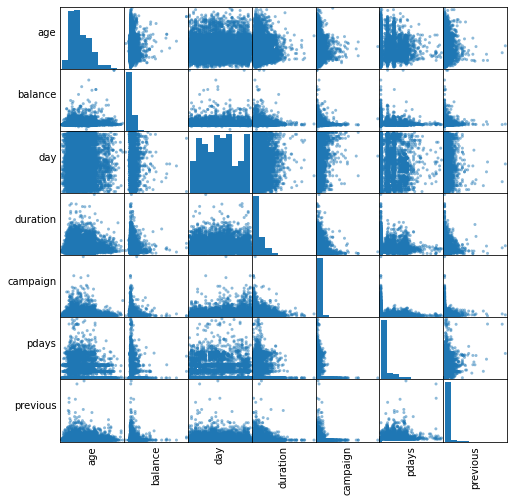

In [22]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [42]:
#drop day and month columns are they are not required
#df = df.drop('day','month')
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns

In [43]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [44]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [45]:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

In [46]:
for c in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = c, outputCol = c + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[c + "classVec"])
    stages += [stringIndexer, encoder]

In [47]:
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

In [48]:
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [i + "classVec" for i in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [49]:
#Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. 
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [50]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [51]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
#print("There are %d training examples and %d test examples." % (train.count(), test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


# Logistic Regression

In [52]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

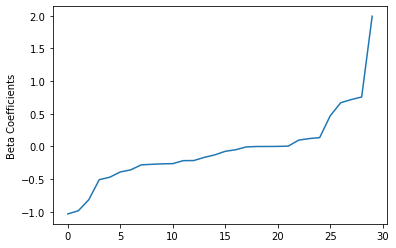

In [53]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

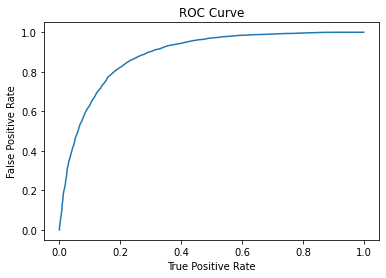

Training set areaUnderROC: 0.8865478305561797


In [54]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

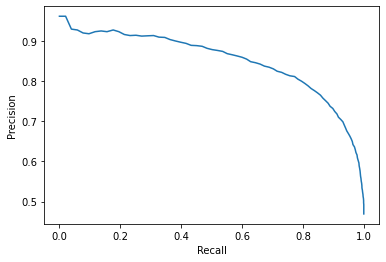

In [55]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [56]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93500470498078...|       0.0|[0.87380233100701...|
| 49|management|  0.0|[2.04809361205494...|       0.0|[0.88575484704982...|
| 52|management|  0.0|[-0.7002122133357...|       1.0|[0.33176517908283...|
| 53|management|  0.0|[1.03431610227355...|       0.0|[0.73775180622517...|
| 58|management|  0.0|[2.74273671692568...|       0.0|[0.93950183380104...|
| 32|management|  0.0|[1.25033004378243...|       0.0|[0.77735698810450...|
| 57|management|  0.0|[1.19540519867322...|       0.0|[0.76770638557283...|
| 52|management|  0.0|[3.26456982709638...|       0.0|[0.96319314409492...|
| 46|management|  0.0|[2.15036209979034...|       0.0|[0.89570260888977...|
| 31|management|  0.0|[1.47751802200863...|       0.0|[0.81419739986183...|
+---+-------

In [62]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions)*100)

Test Area Under ROC 88.37112925002687


# DecisionTreeClassifier

In [63]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [66]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})*100))

Test Area Under ROC: 78.08118726917547


# Random Forest Classifier

In [67]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[15.6540933043595...|       0.0|[0.78270466521797...|
| 49|management|  0.0|[15.3229105243638...|       0.0|[0.76614552621819...|
| 52|management|  0.0|[6.99148109353427...|       1.0|[0.34957405467671...|
| 53|management|  0.0|[14.2760622264025...|       0.0|[0.71380311132012...|
| 58|management|  0.0|[15.8365151435869...|       0.0|[0.79182575717934...|
| 32|management|  0.0|[15.3527668080084...|       0.0|[0.76763834040042...|
| 57|management|  0.0|[14.8487362415329...|       0.0|[0.74243681207664...|
| 52|management|  0.0|[17.1570366000320...|       0.0|[0.85785183000160...|
| 46|management|  0.0|[16.1662856002583...|       0.0|[0.80831428001291...|
| 31|management|  0.0|[15.0422225190135...|       0.0|[0.75211112595067...|
+---+-------

In [68]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})*100))

Test Area Under ROC: 87.67880207006243


# Gradient Boosted Tree Classifier

In [69]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[0.94992370947246...|       0.0|[0.86987425549896...|
| 49|management|  0.0|[1.28281748604659...|       0.0|[0.92861688965145...|
| 52|management|  0.0|[-0.5021429054421...|       1.0|[0.26809961471379...|
| 53|management|  0.0|[0.09646513340517...|       0.0|[0.54808351175538...|
| 58|management|  0.0|[1.05831377292163...|       0.0|[0.89250881497055...|
| 32|management|  0.0|[0.57268875896254...|       0.0|[0.75866558918304...|
| 57|management|  0.0|[0.34932946844840...|       0.0|[0.66789037418062...|
| 52|management|  0.0|[1.33264456943866...|       0.0|[0.93494709840561...|
| 46|management|  0.0|[1.28262818068783...|       0.0|[0.92859178839697...|
| 31|management|  0.0|[1.16094954405484...|       0.0|[0.91067454521219...|
+---+-------

In [70]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})*100))

Test Area Under ROC: 89.35091626908479


In [71]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8954659543871663